## PyVBMC Toy Model

In this notebook we'll walk through how to solve a parameter estimation problem for a toy ODE problem. To get started, import all the packages we'll be needing:

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

## The problem

We have some (noisy) data that obeys the following nonlinear ODE (called the Duffing Equation):

$$\ddot{x} = -\beta x - \epsilon x^3$$

where $\beta,\epsilon > 0 $

We'd like to be able to determine the values of $\beta$ and $\epsilon$ from this trajectory data using PyVBMC. Since we generated the data, we know that $\beta = \epsilon = 1.5$ (a very nonlinear oscillator!), but let's pretend like we don't know that.


To get started let's read in the data and plot it with `matplotlib`:

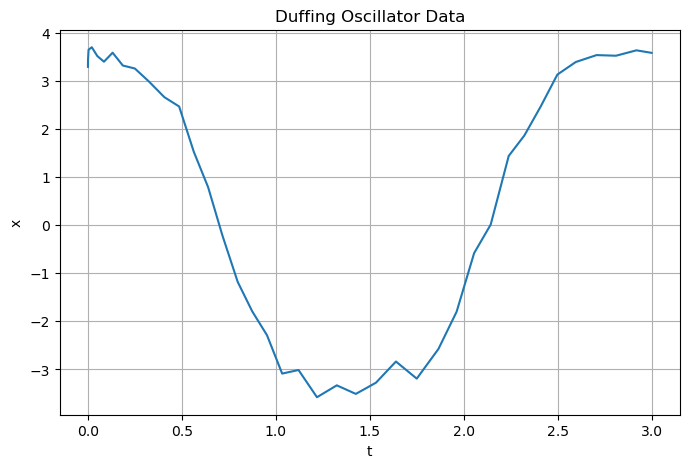

In [2]:
data = pd.read_csv("duffing_oscillator_data_noisy.csv")

t = data["time"]
x_true = data["data"]


plt.figure(figsize=(8,5))
plt.plot(t,x_true)
plt.title('Duffing Oscillator Data')
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.show()

To get our log likelihood, we need a way to generate trajectories of the duffing equation. For this we will use Scipy's `odeint` we'll treat this as a black-box ODE solver for now (I have absolutley no clue how the lsoda algorithm works). Anywho, we need a differential equation function for this just like when we solved ODE's with Julia:

In [3]:
def diffyqs(X, t, epsilon,beta): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    x, vx = X[0], X[1]
    dx = vx
    dv = -beta*x - epsilon * x**3
    return [dx, dv]

We'll also need an initial condition. This will remain the same for the rest of this problem since we're always looking at the same trajectory from the data.

In [4]:
# initial conditions (known from generation of data, or could get from data itself)
initial_condition = [0.0, 3.5]

To see odeint in action, let's generate the noise-free version of this data (since we know the true parameter values we can cheat).

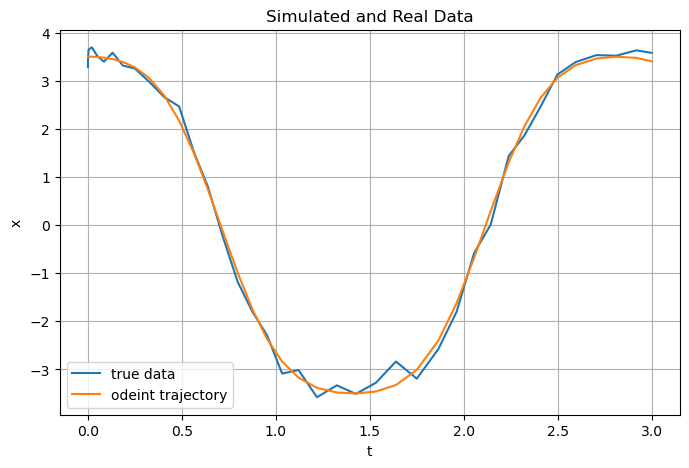

In [6]:
epsilon = 1.5
beta = epsilon

sol = odeint(diffyqs, initial_condition, t, args=(epsilon,beta)) # pass odeint the differential equation, initial condition, time array, and parameters

# plot plot plot
plt.figure(figsize=(8,5))
plt.plot(t,x_true, label = 'true data')
plt.plot(t,sol.T[1], label = 'odeint trajectory') # to get the right part of the solution you have to do this weird transpose index thing
plt.title('Simulated and Real Data')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.show()

Now let's get ready to use PyVBMC. First we'll define a `log_likelihood` function that returns the log of the probability density of a given choice of parameters. Here we assume a normal distribution.

In [8]:
def log_likelihood(theta):
    epsilon,beta = theta # unpack parameters from theta

    sigma = 0.2 # we just know this from when I added gaussian noise to the data, not sure how you would get this in practice (error bars??)

    sol = odeint(diffyqs, initial_condition, t, args=(epsilon,beta)) # get solution of ODE with current choice of params
    
    return np.sum(np.log(1/(sigma * (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol.T[1] - x_true)**2) # normal distribution

Next, we need to define strict and plausible upper and lower bounds for our problem. Admittedley some of these are just picked for convienience. 

In [9]:
D = 2  # 2-D since there are 2 params we're estimating

prior_mu =  np.full((1,D), 5.0) # Mean of the prior (in theory, I think rn this is just being used to get PLB, PUB)  #np.zeros((1, D))
prior_std = 3 * np.ones((1, D)) # std of the prior

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
UB = np.full((1, D), 20.0)  # Upper bounds (picked to be reasonable)

PLB =  prior_mu - prior_std  # Plausible lower bounds     # PLB = scs.norm.ppf(0.1587, prior_mu, prior_std)
PUB =  prior_mu + prior_std  # Plausible upper bounds     # PUB = scs.norm.ppf(0.8413, prior_mu, prior_std)

x0 = np.copy(prior_mu) # starting point for inference   # 1.5 * np.ones((1, D))

We'll first use VBMC with a uniform box prior:

In [10]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -328.39       184.06 474909827433953.69        2        inf     start warm-up
     1         15           3.27        33.12       181.99        2        inf     
     2         20           1.09        11.51        10.59        2        295     
     3         25          12.90       209.39       546.83        2   1.36e+04     
     4         30           4.37         0.87       121.87        2    2.9e+03     
     5         35           4.73         0.00         0.07        2       2.93     
     6         40           4.73         0.00         0.00        2     0.0346     
     7         45           4.73         0.00         0.00        2      0.068     
     8         50           4.73         0.00         0.00        2     0.0783     
     9         55           4.71         0.00         

We can see convergence here:

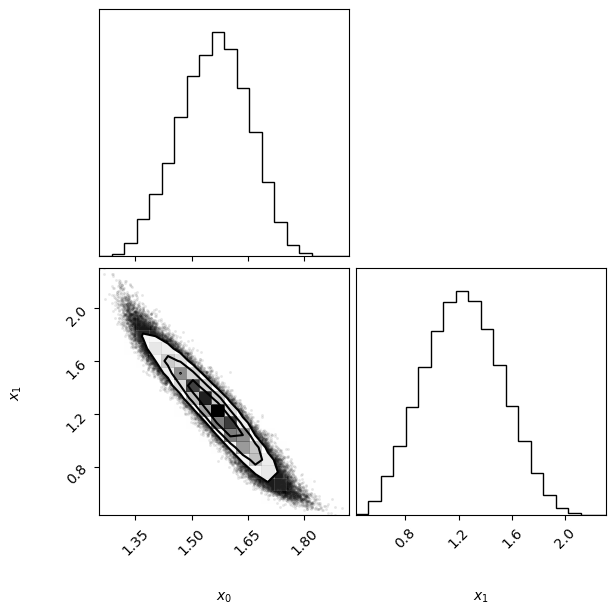

In [11]:
vp.plot();

Sampling the posterior lets us find values of interest like the mean values of posterior:

In [15]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
#print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [1.5593357  1.23476665]


We can use these mean values with odeint to produce a new trajcetory and see how good PyVBMC did:

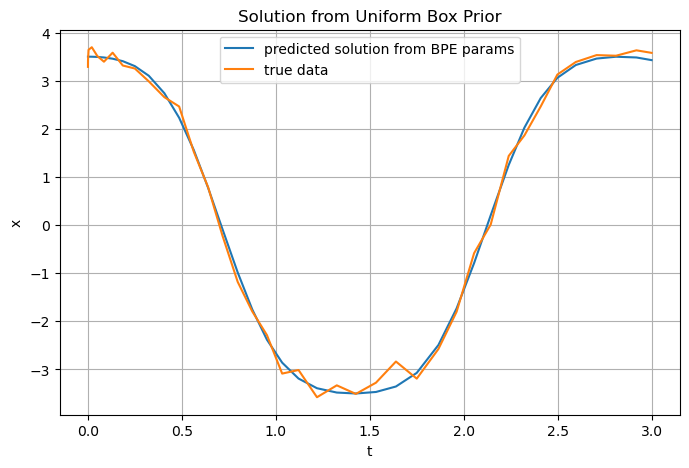

In [18]:
epsilon =  post_mean[0]
beta = post_mean[1]

sol = odeint(diffyqs, initial_condition, t, args=(epsilon,beta))

plt.figure(figsize=(8,5))
plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol.T[1], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

Now, lets repeat the process of running PyVBMC but with normal distributions for the prior:

In [43]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = [scs.norm(loc = 5),scs.norm(loc = 5)]) # loc is location (mu), could also specify scale for standard deviation (sigma). List twice because 2d problem

vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -869.62        72.15  64082511.63        2        inf     start warm-up
     1         15         153.20       196.83      1839.53        2        inf     
     2         20          -8.75         5.28        75.80        2   2.34e+03     
     3         25          -9.08         0.31        31.44        2        743     
     4         30          -5.65         0.44        11.17        2        276     
     5         35           1.09        76.25       139.38        2   3.56e+03     
     6         40          -3.90         0.05        30.05        2        725     
     7         45          -3.86         0.00         0.01        2      0.299     
     8         50          -3.87         0.00         0.01        2      0.309     
     9         55          -3.89         0.00         0.01  

The approximate posterior mean is: [1.48689966 1.47371653]


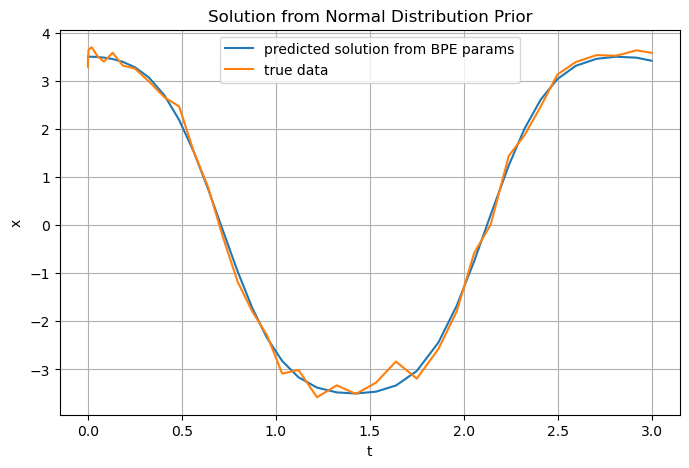

In [44]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate posterior mean is:", post_mean)


epsilon =  post_mean[0]
beta = post_mean[1]

sol = odeint(diffyqs, initial_condition, t, args=(epsilon,beta))

plt.figure(figsize=(8,5))
plt.title("Solution from Normal Distribution Prior")
plt.plot(t,sol.T[1], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

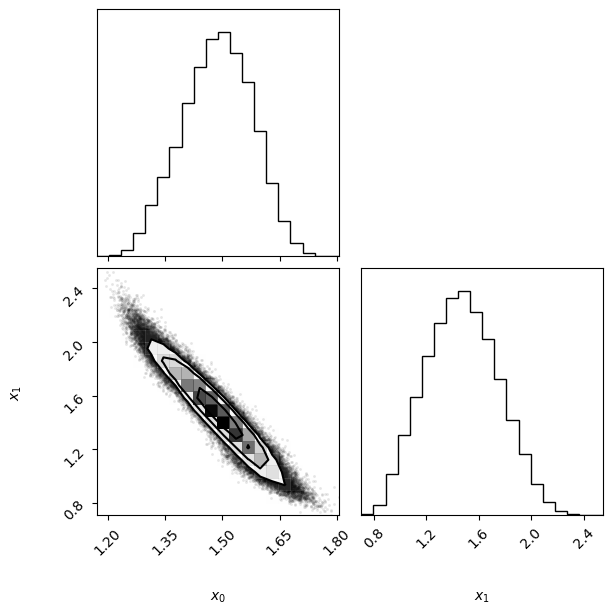

In [46]:
vp.plot();

### Repeating this exercise with the initial velocity also as a parameter:

In [26]:
def log_likelihood(theta):
    epsilon,beta, v0 = theta # unpack parameters from theta

    sigma = 0.2 # we just know this from when I added gaussian noise to the data, not sure how you would get this in practice (error bars??)

    sol = odeint(diffyqs, [v0, 3.5], t, args=(epsilon,beta)) # get solution of ODE with current choice of params
    
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol.T[1] - x_true)**2) # normal distribution

D = 3

prior_mu =  np.full((1,D), 5.0) 
prior_std = 3 * np.ones((1, D)) 

LB = np.full((1, D), 0.0) 
LB[0][2] = -4 ## initial velocity has different possible range of values
UB = np.full((1, D), 20.0)  
UB[0][2] = 4

PLB =  prior_mu - prior_std  # Plausible lower bounds
PUB =  prior_mu + prior_std  # Plausible upper bounds
PLB[0][2] = -2
PUB[0][2] = 2

x0 = np.copy(prior_mu) # starting point 
x0[0][2] = 0.5

In [27]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = [scs.norm(loc = 1.5),scs.norm(loc = 1.5), scs.norm(loc = 0)])

vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        2029.56      4615.97 473023146007768.88        2        inf     start warm-up
     1         15         -74.11       729.38       211.92        2        inf     
     2         20         371.98       712.60      2620.65        2   5.43e+04     
     3         25         -76.72        38.64        61.44        2   2.81e+03     
     4         30         875.24      2184.11     27288.18        2   5.36e+05     
     5         35          76.65       711.58      1457.55        2   3.31e+04     
     6         40          62.93       144.05      1923.19        2   3.75e+04     
     7         45          15.43         6.05        81.66        2   1.75e+03     
     8         50           4.63         0.56        11.52        2        260     
     9         55         339.90       784.86       45

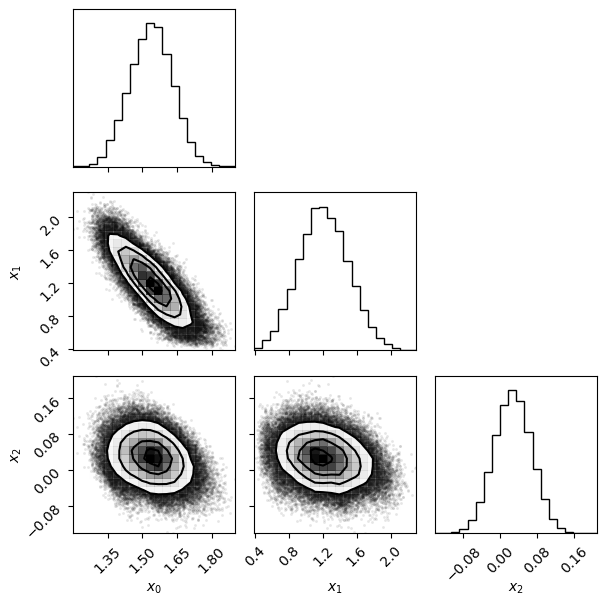

In [35]:
vp.plot();

The approximate posterior mean is: [1.53681472 1.20952046 0.02676149]


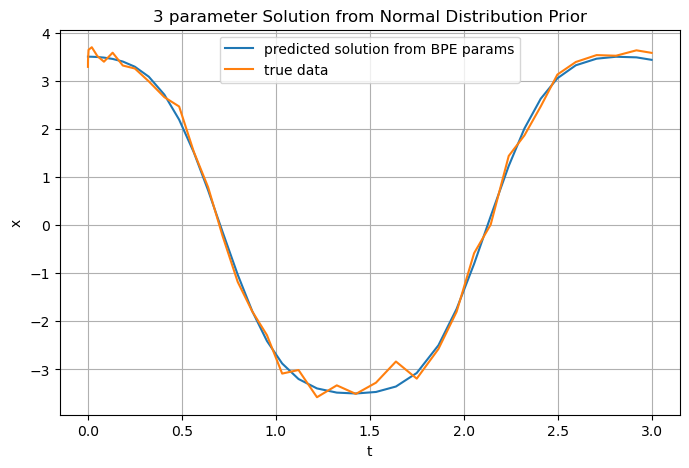

In [32]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate posterior mean is:", post_mean)


epsilon =  post_mean[0]
beta = post_mean[1]

sol = odeint(diffyqs, [post_mean[2],3.5], t, args=(epsilon,beta))

plt.figure(figsize=(8,5))
plt.title("3 parameter Solution from Normal Distribution Prior")
plt.plot(t,sol.T[1], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()